In [1]:
%matplotlib inline 

# Regression
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Regression on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [4]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [5]:
def replace_ws(the_string):
    return str(the_string).replace(" ", "_")

In [6]:
def add_days_to_next_order(order_df):
    orders = order_df.copy()
    orders["days_to_next_order"] = np.nan
    for index, cur_order in orders.iterrows():
        next_order_number = cur_order.order_number + 1
        user_id = cur_order.user_id
        next_order_df = orders.query("user_id == " + str(user_id) + " and  order_number == " + str(next_order_number))
        if(next_order_df.shape[0] == 1):
            next_order = next_order_df.iloc[0]
            days_to_next_order = next_order.days_since_prior_order
            if(np.isfinite(days_to_next_order)):
                orders.loc[index, 'days_to_next_order'] = days_to_next_order
    return orders

In [7]:
def add_each_aisle_to_df(df):
    df_aisles = df.copy().merge(aisles, on="aisle_id")
    for index, row in aisles.iterrows():
        aisle_name = replace_ws(row.aisle)
        df_aisles[aisle_name] = 0
    return df_aisles

In [8]:
def group_aisle_in_df(df_aisles):
    # Create new df with only the column names
    df = df_aisles.copy()
    df.drop(df.index, inplace=True)
    order_ids = df_aisles.order_id.unique().tolist()
    for order_id in order_ids:
        temp_df = df_aisles.query("order_id == " + str(order_id))
        # Need a copy as not to modify something we are iterarting over
        first_row = temp_df.copy().head(1)
        for i, temp_row in temp_df.iterrows():
            temp_aisle_name = replace_ws(temp_row.aisle)
            # If the aisle is present, set it to 1
            first_row[temp_aisle_name] = 1
        # Add the aggregated entry
        df = pd.concat([df, first_row])
    df = df.drop('aisle', axis=1)
    df = df.drop('aisle_id', axis=1)
    df = df.drop('order_id', axis=1)
    return df    

### Import Data

#### Test and training split for all users

In [9]:
test_percentage = 0.2
orders = read_csv_file(my_orders_file)
orders = add_days_to_next_order(orders)
# Can use this to estimate what would be ordered
orders_with_no_next_order = orders[orders['days_to_next_order'].isnull()]
# Can split this into train and test
orders_with_next_order = orders[~orders['days_to_next_order'].isnull()]
train_orders, test_orders = train_test_split(orders_with_next_order, test_size=test_percentage)
print("Training size is :", train_orders.shape[0])
print("Testing size is :", test_orders.shape[0])

Training size is : 228
Testing size is : 58


#### Test and training split for specific user

In [10]:
count_orders = (orders
                .groupby("user_id")
                .size()
                .reset_index(name="count")
                .sort_values(by=['count'], ascending=False)
               )
# Get the most frequent user as this will have the most data associated with it
most_frequeny_user_id =  count_orders.iloc[0].user_id
single_user_orders = orders.query("user_id == " + str(most_frequeny_user_id))
user_train_orders, user_test_orders = train_test_split(single_user_orders, test_size=test_percentage)
print("User id for single investigation :", most_frequeny_user_id)
print("Training size for single user is :", user_train_orders.shape[0])
print("Testing size for single user is is :", user_test_orders.shape[0])

User id for single investigation : 47562
Training size for single user is : 71
Testing size for single user is is : 18


#### Import the Other Data

In [11]:
products = read_csv_file(products_file)
aisles = read_csv_file(aisles_file)
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])

## Aisle Rollup
***

### Merge Product and Aisle to the data

In [12]:
train_orders_prod = train_orders.merge(orders_products, on="order_id")
train_orders_prod = train_orders_prod.merge(products, on="product_id")

test_orders_prod = test_orders.merge(orders_products, on="order_id")
test_orders_prod = test_orders_prod.merge(products, on="product_id")

train_orders_prod.head()

,Unnamed: 0_x,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_next_order,Unnamed: 0_y,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,790804,898713,47562,prior,7,3,17,2.0,5.0,8513496,40174,1,1,2% Reduced Fat Organic Milk,84,16
1,790816,2606575,47562,prior,19,1,8,5.0,2.0,24715429,40174,1,1,2% Reduced Fat Organic Milk,84,16
2,790846,1618671,47562,prior,49,1,7,7.0,1.0,15339833,40174,1,1,2% Reduced Fat Organic Milk,84,16
3,790828,228590,47562,prior,31,3,7,7.0,1.0,2167846,40174,1,1,2% Reduced Fat Organic Milk,84,16
4,790868,1666629,47562,prior,71,3,7,2.0,2.0,15795661,40174,2,1,2% Reduced Fat Organic Milk,84,16


### Extract Desired Columns

In [13]:
key_cols = ["order_id", "days_to_next_order", "aisle_id"]
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,aisle_id
0,898713,5.0,84
1,2606575,2.0,84
2,1618671,1.0,84
3,228590,1.0,84
4,1666629,2.0,84


### Add the Aisle Columns

In [14]:
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)

df_with_aisle_info_train.head()

,order_id,days_to_next_order,aisle_id,aisle,prepared_soups_salads,specialty_cheeses,energy_granola_bars,instant_foods,marinades_meat_preparation,other,...,trail_mix_snack_mix,feminine_care,body_lotions_soap,tortillas_flat_bread,frozen_appetizers_sides,hot_cereal_pancake_mixes,dry_pasta,beauty,muscles_joints_pain_relief,specialty_wines_champagnes
0,898713,5.0,84,milk,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2606575,2.0,84,milk,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1618671,1.0,84,milk,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,228590,1.0,84,milk,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1666629,2.0,84,milk,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Populate the Aisle Columns

In [15]:
# Aggregates the data so we have days to next order with the aisles required checked
df_aisle_group_train = group_aisle_in_df(df_with_aisle_info_train)
df_aisle_group_test = group_aisle_in_df(df_with_aisle_info_test)

df_aisle_group_train.head()

,days_to_next_order,prepared_soups_salads,specialty_cheeses,energy_granola_bars,instant_foods,marinades_meat_preparation,other,packaged_meat,bakery_desserts,pasta_sauce,...,trail_mix_snack_mix,feminine_care,body_lotions_soap,tortillas_flat_bread,frozen_appetizers_sides,hot_cereal_pancake_mixes,dry_pasta,beauty,muscles_joints_pain_relief,specialty_wines_champagnes
0,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preparing the data for modelling

In [16]:
# Target
y_train = df_aisle_group_train['days_to_next_order'].copy()
X_train = df_aisle_group_train.copy() 
# Feature
X_train.drop(['days_to_next_order'], axis=1, inplace=True)

# Testing
y_test = df_aisle_group_test['days_to_next_order'].copy()
X_test = df_aisle_group_test.copy() 
# Feature
X_test.drop(['days_to_next_order'], axis=1, inplace=True)

X_train.head()

,prepared_soups_salads,specialty_cheeses,energy_granola_bars,instant_foods,marinades_meat_preparation,other,packaged_meat,bakery_desserts,pasta_sauce,kitchen_supplies,...,trail_mix_snack_mix,feminine_care,body_lotions_soap,tortillas_flat_bread,frozen_appetizers_sides,hot_cereal_pancake_mixes,dry_pasta,beauty,muscles_joints_pain_relief,specialty_wines_champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Generate the Model

In [17]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.intercept_

11.907358756097015

In [18]:
# See the coefficients
#model.coef_

### Find the best feature/aisle

In [25]:
def find_best_feature(X, y, X_test, y_test):
    n_features = X.shape[1]
    # Not zero as some negative scores can happen
    max_score = -100000
    max_feature = None
    for i in range(n_features):
        feature = X.columns[i]
        X_subset = X[[feature]]
        X_test_subset = X_test[[feature]]
        model.fit(X_subset, y)
        # R squared metric
        score = model.score(X_test_subset, y_test)
        if score > max_score:
            max_score = score
            max_feature = feature
    if max_feature is None :
        print("Issue, max feature not found, size", n_features)
        print(X.columns.values)
    return (max_score, max_feature)
find_best_feature(X_train, y_train, X_test, y_test)

(0.11517702600148061, 'milk')

### Find best features in Order and calculate scores

In [26]:
n_features = X_train.shape[1]
scores = [0]
X_selection = X_train.copy()
X_test_selection = X_test.copy()
X_subsets = pd.DataFrame(index=X_train.index)
X_test_subsets = pd.DataFrame(index=X_test.index)

for i in range(n_features):
    max_score, next_best_feature = find_best_feature(X_selection, y_train, X_test_selection, y_test)
    print('Next best feature = ', next_best_feature)
    X_subset = X_selection[[next_best_feature]]
    X_test_subset = X_test_selection[[next_best_feature]]
    
    X_subsets[next_best_feature] = X_subset
    X_test_subsets[next_best_feature] = X_test_subset
    
    model.fit(X_subsets, y_train)
    scores.append(model.score(X_test_subsets, y_test))
    
    X_selection.drop([next_best_feature], axis=1, inplace=True)
    X_test_selection.drop([next_best_feature], axis=1, inplace=True)

Next best feature =  milk
Next best feature =  hot_dogs_bacon_sausage
Next best feature =  first_aid
Next best feature =  instant_foods
Next best feature =  trash_bags_liners
Next best feature =  ice_cream_ice
Next best feature =  frozen_meat_seafood
Next best feature =  frozen_breakfast
Next best feature =  tofu_meat_alternatives
Next best feature =  butter
Next best feature =  laundry
Next best feature =  salad_dressing_toppings
Next best feature =  packaged_cheese
Next best feature =  packaged_vegetables_fruits
Next best feature =  marinades_meat_preparation
Next best feature =  frozen_appetizers_sides
Next best feature =  tea
Next best feature =  soft_drinks
Next best feature =  popcorn_jerky
Next best feature =  canned_meat_seafood
Next best feature =  cleaning_products
Next best feature =  energy_granola_bars
Next best feature =  crackers
Next best feature =  preserved_dips_spreads
Next best feature =  baking_ingredients
Next best feature =  frozen_meals
Next best feature =  beer

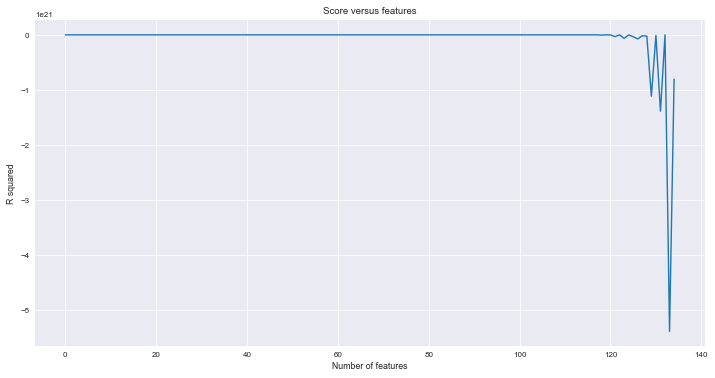

In [21]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(scores)

In [22]:
predictors = X_train.columns
coef = pd.Series(model.coef_,predictors).sort_values()
coef

spices_seasonings               -1.723668e+14
juice_nectars                   -1.236008e+14
fresh_dips_tapenades            -1.683925e+11
energy_sports_drinks            -1.497520e+11
soup_broth_bouillon             -1.267201e+11
digestion                       -3.652856e+10
facial_care                     -7.691325e+09
protein_meal_replacements       -4.226541e+09
dish_detergents                 -1.526710e+09
soft_drinks                     -1.274075e+09
frozen_pizza                    -9.655816e+08
spreads                         -3.888268e+06
more_household                  -7.491353e+05
lunch_meat                      -4.216549e+01
mint_gum                        -1.783186e+01
dry_pasta                       -1.519143e+01
cat_food_care                   -1.492968e+01
cream                           -1.393390e+01
packaged_cheese                 -1.217188e+01
frozen_breakfast                -1.194671e+01
packaged_poultry                -1.086367e+01
breakfast_bars_pastries         -1

In [23]:
# NOW WE WANT TO USE PCA/REGULARISATION AND REMOVE SOME UNNEEDED INFO/AISLES

In [24]:
# DONT FORGET TO MEAN CENTRE